# Hierarchical Bayesian Modelling in Real life

This notebook was created for PyData NYC 2018.  

### Import all necessary libraries

In [3]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn import metrics
import seaborn as sns
from theano import shared

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
def run_model(model, m_name, trace_num=5000, tune=1000):
    with model:
        trace = pm.sample(trace_num, tune=tune)[tune:]
    pm.plots.traceplot(trace)
    print("\nWAIC: {}".format(pm.stats.waic(trace, model=model)))
    return(trace)

## Background

## Campaign spend data

This data comes from X digital marketing campaigns since 2016.  They are distributed across Y businesses.  Besides business ID, we have a set of variables that will be important to the model.  We also code each of them as an id, which will be useful later in our modelling.:

billed_amount : The amount billed for the campaign.  This is based on real data, but is not itself real.  Privacy issues and all that.

log_billed_amount : The log of billed_amount.  This is to enforce a more normal distribution on our outcome variable.  It's not necessary, but it's easier for the analysis.  Typically, spend amounts are log-normally distributed.  There's a fair number of high spenders, and a large number of low spenders.

product : The products we'll be focused on. They are as follows:
    - Display = Display advertising, like you might see on a website
    - SEM = Search Engine Marketing, dealing with "sponsored" search results in Google and Bing
    - SEO = Search Engine Optimization, general name for services that aim to increase "organic" traffic, or traffic outside of paid services
    - Social = Advertising on social networks, specifically Facebook and Instagram
    - Email = Direct email advertising, like you might get in your inbox.
    
size : Size of the company.  We have grouped this into four categories: Less than 50 employees, between 50 and 100,  more than 100 and "unavailable".  Unavailable just means we were unable to capture this information.

region : The region of the company headquarters.  There are four: Northeast, South, Midwest and West.

In [49]:
campaign_data = pd.read_csv('spend_data_distribute.csv')

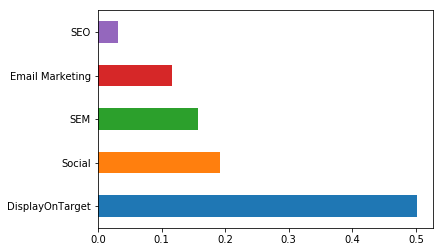

In [50]:
campaign_data['product'].value_counts(normalize=True).plot(kind='barh')

In [51]:
# drop those without industry
campaign_data = campaign_data[campaign_data.industry!='unavailable']
campaign_data.shape

(13092, 11)

In [52]:
#campaign_data = campaign_data.sample(frac=.3)

In [53]:
campaign_data.region_idx.value_counts()

0    5745
1    3570
2    2685
3    1092
Name: region_idx, dtype: int64

In [54]:
# for pooled: need dummy variables
dummy_dict = {}
for c in ['product', 'size', 'region', 'industry']:
    dummy_dict[c] = pd.get_dummies(campaign_data[c]).iloc[:,1:]

In [56]:
model_dict = {}
# non-hierarchical / pooled
with pm.Model() as model:
    product_betas = pm.Normal('product_betas', mu=0., sd=1.0, 
                              shape=campaign_data['product'].nunique()-1)
    size_betas = pm.Normal('size_betas', mu=0., sd=1.0, 
                           shape=campaign_data['size'].nunique()-1)
    region_betas = pm.Normal('region_betas', mu=0., sd=1.0,
                             shape=campaign_data['region'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=0., sd=1.0,
                               shape=campaign_data['industry'].nunique()-1)
    intercept = pm.Normal('Intercept', 0., sd=1.0)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = intercept+pm.math.dot(product_betas, dummy_dict['product'].values.T)+\
        pm.math.dot(size_betas, dummy_dict['size'].values.T)+\
        pm.math.dot(region_betas, dummy_dict['region'].values.T)+\
        pm.math.dot(industry_betas, dummy_dict['industry'].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['pooled'] = model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, industry_betas, region_betas, size_betas, product_betas]
Sampling 2 chains: 100%|██████████| 8000/8000 [13:38<00:00,  9.78draws/s] 
The number of effective samples is smaller than 10% for some parameters.



WAIC: WAIC_r(WAIC=32325.481869365191, WAIC_se=197.57785775771069, p_WAIC=32.398084636626479, var_warn=0)


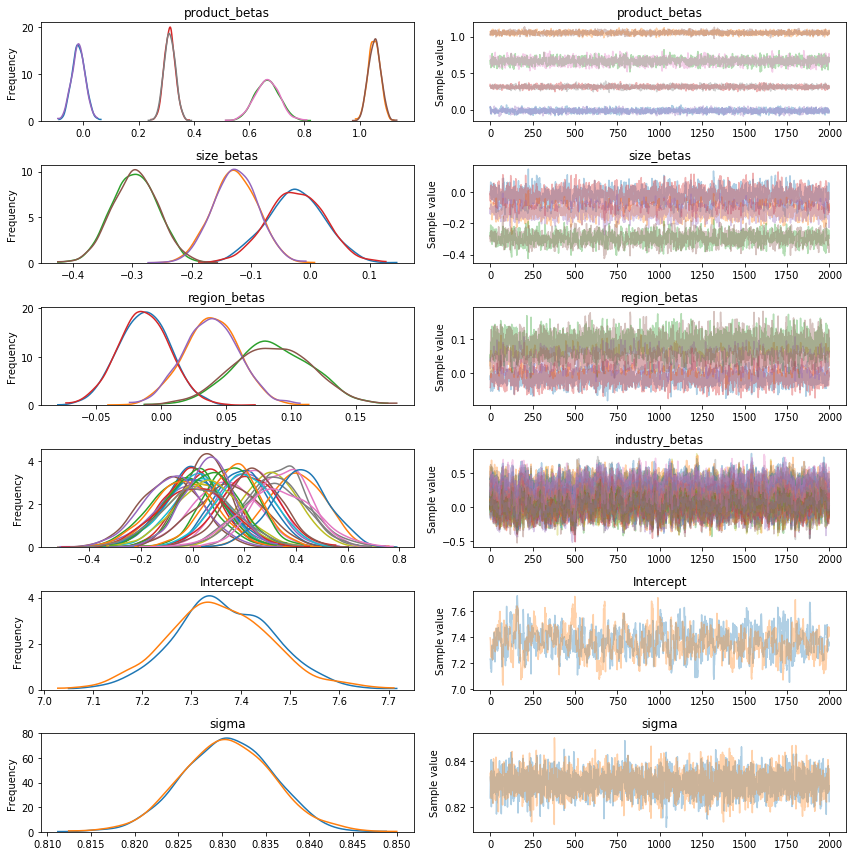

In [57]:
trace_dict = {}
trace_dict['pooled'] = run_model(model_dict['pooled'], 'pooled', trace_num=3000, tune=1000)

In [58]:
# hiearchical - product
with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)
    
    # product-level intercept
    product_alphas = pm.Normal('product_alphas', mu=mu_a, sd=sigma_a, 
                              shape=campaign_data['product'].nunique())
    
    # betas
    region_betas = pm.Normal('region_betas', mu=mu_b, sd=sigma_b,
                             shape=campaign_data['region'].nunique()-1)
    size_betas = pm.Normal('size_betas', mu=mu_b, sd=sigma_b, 
                           shape=campaign_data['size'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=mu_b, sd=sigma_b,
                               shape=campaign_data['industry'].nunique()-1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = product_alphas[campaign_data['product_idx'].values]+\
        pm.math.dot(size_betas, dummy_dict['size'].values.T)+\
        pm.math.dot(region_betas, dummy_dict['region'].values.T)+\
        pm.math.dot(industry_betas, dummy_dict['industry'].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['product_alphas'] = model

In [59]:
# hiearchical - product and region
with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)    
    
    # product and region-level intercepts
    product_alphas = pm.Normal('product_alphas', mu=mu_a, sd=sigma_a, 
                              shape=campaign_data['product'].nunique())
    region_alphas = pm.Normal('region_alphas', mu=mu_a, sd=sigma_a,
                         shape=campaign_data['region'].nunique())
    
    # betas
    size_betas = pm.Normal('size_betas', mu=mu_b, sd=sigma_b, 
                           shape=campaign_data['size'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=mu_b, sd=sigma_b,
                               shape=campaign_data['industry'].nunique()-1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = product_alphas[campaign_data['product_idx'].values]+\
        region_alphas[campaign_data['region_idx'].values]+\
        pm.math.dot(size_betas, dummy_dict['size'].values.T)+\
        pm.math.dot(industry_betas, dummy_dict['industry'].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['product_region_alphas'] = model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, industry_betas, size_betas, region_betas, product_alphas, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 2 chains: 100%|██████████| 8000/8000 [11:09<00:00, 11.94draws/s] 
The acceptance probability does not match the target. It is 0.8841105894, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



WAIC: WAIC_r(WAIC=32319.88866052559, WAIC_se=197.38720959462248, p_WAIC=27.555952229111192, var_warn=0)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, industry_betas, size_betas, region_alphas, product_alphas, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 2 chains: 100%|██████████| 8000/8000 [21:17<00:00,  6.26draws/s] 
The number of effective samples is smaller than 25% for some parameters.



WAIC: WAIC_r(WAIC=32321.245724428009, WAIC_se=197.37505494597011, p_WAIC=28.383087921544369, var_warn=0)


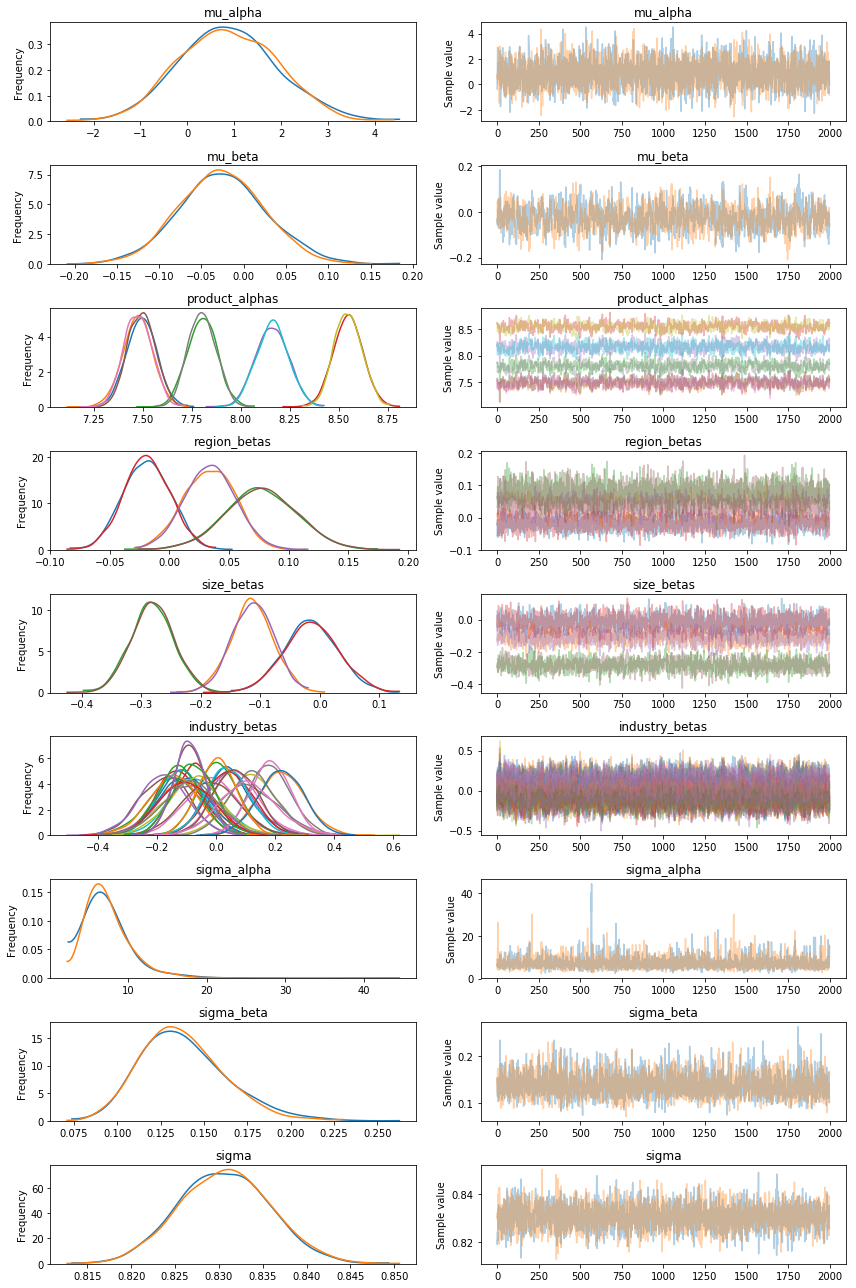

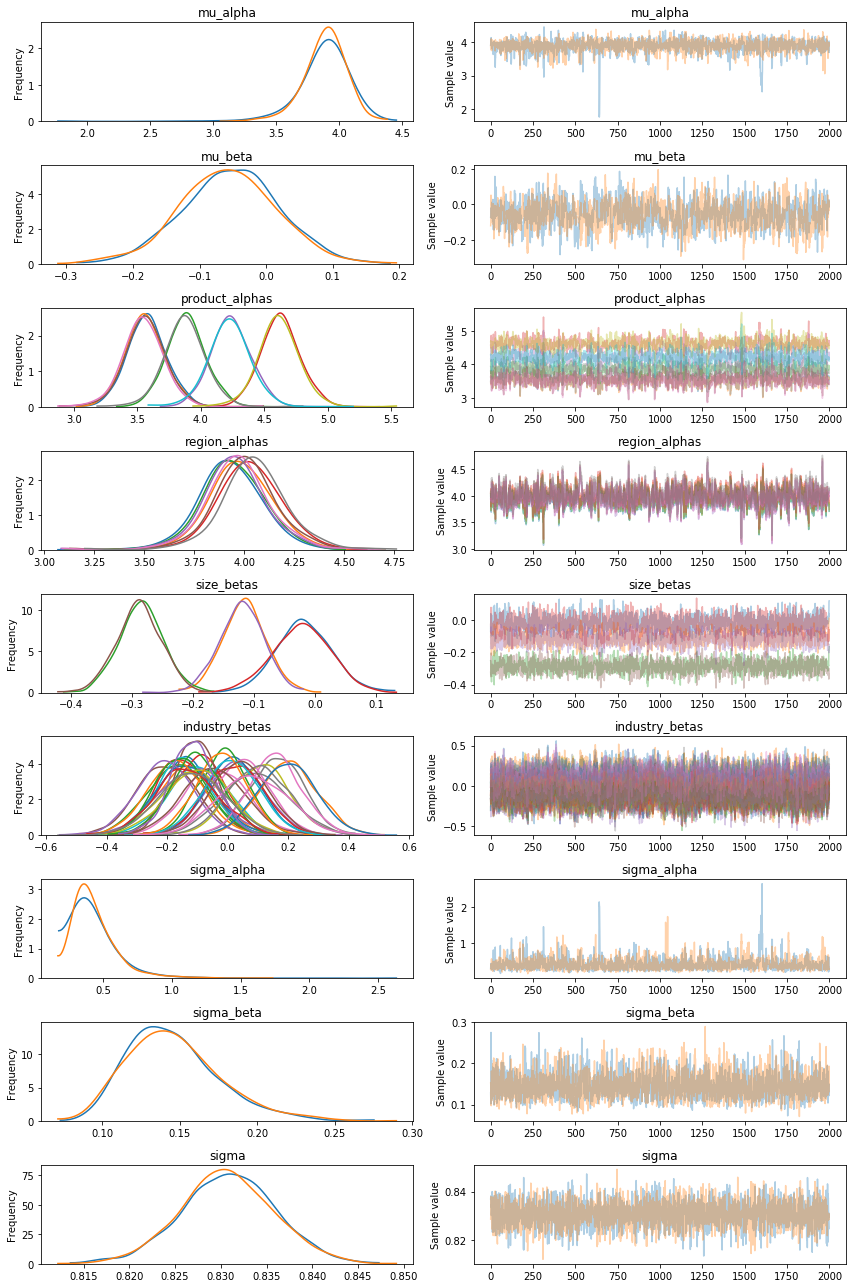

In [60]:
for m in ['product_alphas', 'product_region_alphas']:
    trace_dict[m] = run_model(model_dict[m], m, trace_num=3000, tune=1000)

In [ ]:
ppc_dict = {}
fig, ax = plt.subplots()
channel = 'SEM'

label_dict = {'base':'pooled', 'ch_fe': 'product', 'ch_reg_fe': 'product+region'}

for m in ['base', 'ch_fe', 'ch_reg_fe']:
    print(m)
    ppc_dict[m] = pm.sample_ppc(trace_dict[m], model=model_dict[m], samples=1000)['y']
    if m == 'ch_separate':
        pred_y = ppc_dict[m][0]
    else:
        pred_y = ppc_dict[m][0][(X_sample.product_family==channel).values]
    if m in label_dict:
        sns.kdeplot(pred_y, ax=ax, label=label_dict[m])
    else:
        sns.kdeplot(pred_y, ax=ax, label=m)
    actual_y = X_sample[X_sample.product_family==channel]['log_amount']
    mae = metrics.mean_absolute_error(actual_y, pred_y)
    print mae/actual_y.std()
    print metrics.r2_score(actual_y, pred_y)
sns.kdeplot(actual_y, ax=ax, label='actual')
ax.set_xlabel('log spend')
ax.set_title('Predicted ranges vs actual')

In [ ]:
waics_dict = {}
for k in trace_dict:
    print(k)
    waics_dict[k] = pm.waic(trace_dict[k], model_dict[k])
    print(waics_dict[k])
    

In [ ]:
ppc_dict = {}
fig, ax = plt.subplots()

for m in model_dict:
    print m
    ppc_dict[m] = pm.sample_ppc(trace_dict[m], model=model_dict[m], samples=1000)['y']
    pred_y = ppc_dict[m][10]
    sns.kdeplot(pred_y, ax=ax, label=m)
    actual_y = X_sample['log_amount']
    mae = metrics.mean_absolute_error(actual_y, pred_y)
    print mae/actual_y.std()
    print metrics.r2_score(actual_y, pred_y)
sns.kdeplot(actual_y, ax=ax, label='actual')

In [ ]:
# Changing values here will also change values in the model
predictors.set_value(X[model_feats].iloc[:100].values.T)